In [1]:
import hdphmm
from hdphmm import generate_timeseries as gent
import numpy as np
import matplotlib.pyplot as plt
import generate_timeseries as gent2

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from itertools import combinations, permutations
from matplotlib.lines import Line2D



def multicolored_line_collection(x, y, z, colors, lw=2):
    """ Color a 2D line based on which state it is in

    :param x: data x-axis values
    :param y: data y-axis values
    :param z: values that determine the color of each (x, y) pair
    """

    nstates = colors.shape[0]
    # come up with color map and normalization (i.e. boundaries of colors)

    cmap = ListedColormap(colors)
    bounds = np.arange(-1, nstates) + 0.1
    norm = BoundaryNorm(bounds, cmap.N)  # add

    # create line segments to color individually
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Set the values used for colormapping
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(z)
    lc.set_linewidth(lw)

    z2 = np.unique(z)

    def make_proxy(zvalue, scalar_mappable, **kwargs):
        color = scalar_mappable.cmap(scalar_mappable.norm(zvalue))
        return Line2D([0, 1], [0, 1], color=color, **kwargs)
    
    proxies = [make_proxy(item, lc, linewidth=2) for item in z2]
    

    return lc, proxies

def organize_states(true_states, true_state_labels, found_states, estimated_states):
    """ determine the optimal match between the estimated state sequence and the found state labels

    :param true_states:
    :param true_state_labels:
    :param found_states:
    :param estimated_states:
    :return:
    """

    # if too few states were found, add a dummy state in order to make following calculations work
    dummies = []
    if len(found_states) < len(true_state_labels):
        print('Less states were found than exist...adding a dummy state')
        for i in range(len(true_state_labels) - len(found_states)):
            #dummy = sum(found_states)  # add all the found states to get a unique dummy state label
            dummy = 0
            while dummy in found_states:
                dummy += 1
            found_states.append(dummy)
            dummies.append(dummy)

    # We need to identify which states match up with the known labels. I think the Munkres algorithm is a more
    # efficient way of doing this
    mismatches = []  # count up the number of mismatches for each subset and its permutations
    subsets = list(combinations(found_states, len(true_state_labels)))
    nperm = len(list(permutations(subsets[0])))
    for sub in subsets:
        p = permutations(sub)
        for i, perm in enumerate(p):
            M = dict(zip(true_state_labels, perm))
            wrong = 0
            for s, estimate in enumerate(estimated_states):
                if estimate != M[true_states[s]]:
                    wrong += 1
            mismatches.append(wrong)

    mindex = np.argmin(mismatches)  # index of minimum number of wrong label assignments
    subset = subsets[(mindex // nperm)]  # subset number of minimum wrong labels
    p = list(permutations(subset))  # permutations of subset
    states = list(p[mindex % nperm])  # the states listed in subset in the order that leads to minimum wrong labels

    return states

def summarize_results(ihmm, cmap=plt.cm.jet, traj_no=0, plot_dim='all', savename=None, shuffle=False,
                          crange=(50, 225)):
        """ Plot estimated state sequence. If true labels exist, compare those.
        """

        # Get data
        estimated_states = ihmm.z[traj_no, :]
        dim = ihmm.trajectories.shape[2]  # number of dimensions of trajectory
        shift = 1.5 * ihmm.trajectories[:, traj_no, :].max()

        found_states = list(np.unique(estimated_states))

        nT = len(estimated_states)

        state_counts = [list(estimated_states).count(s) for s in found_states]
        # print(state_counts)
        # print(estimated_states[:25])

        print('Found %d unique states' % len(found_states))

        if ihmm.labels is not None:

            true_states = ihmm.labels[ihmm.order:, traj_no]
            true_state_labels = list(np.unique(true_states))
            nstates = len(true_state_labels)
            print('%d states were used to generate this data' % nstates)
            states = organize_states(true_states, true_state_labels, found_states, estimated_states)

        else:
            states = found_states

        # Print estimate properties
        estimated_transition_matrix = ihmm.pi_z[tuple(np.meshgrid(states, states))].T

        # normalize so rows sum to 1
        for i in range(len(states)):
            estimated_transition_matrix[i, :] /= estimated_transition_matrix[i, :].sum()

        print(np.diagonal(estimated_transition_matrix))
        # print('\nEstimated Transition Matrix:\n')
        # print(estimated_transition_matrix)

        if ihmm.labels is not None:

            actual_transition_matrix = ihmm.actual_T
            # rms = np.sqrt(np.square(estimated_transition_matrix - actual_transition_matrix).mean())
            #
            # print('\nActual Transition Matrix:\n')
            # print(actual_transition_matrix)
            #
            # print('\nRoot mean squared error between estimated and true matrices: %.4f\n' % rms)

            # give extra states their own labels
            diff = len(found_states) - len(states)  # difference between no. of found states and actual no. of states
            extra_states = [x for x in found_states if x not in states]
            if diff > 0:
                for i in range(diff):
                    states.append(extra_states[i])
                    true_state_labels.append(nstates + i)

            M = dict(zip(true_state_labels, states))  # dictionary of state numbers mapped to original labels
            reverseM = dict(zip(states, true_state_labels))

            # determine the indices where the wrong label assignments occur
            wrong_label = []
            for s, estimate in enumerate(estimated_states):
                if estimate != M[true_states[s]]:
                    wrong_label.append(s)

            print('Correctly identified %.1f %% of states' % (100 * (1 - (len(wrong_label) / len(estimated_states)))))
        else:
            M = dict(zip(found_states, np.arange(len(found_states))))

        # MLE autoregressive coefficients and covariance matrices
        # print(ihmm.theta['A'][..., states[2], 0])
        # print(np.linalg.inv(ihmm.theta['invSigma'][..., states[2], 0]))

        # Make a color-coded plot

        # randomly assign color values from colormap

        #colors = np.array([cmap(i) for i in np.random.choice(np.arange(cmap.N), size=self.max_states)])
        #shown_colors = np.array([cmap(i) for i in np.linspace(50, 225, len(found_states)).astype(int)])
        colors = np.array([cmap(i) for i in np.linspace(crange[0], crange[1], len(found_states)).astype(int)])

        if shuffle:
            np.random.shuffle(colors)

        #colors = np.array([cmap(i) for i in np.linspace(50, 225, np.max(found_states) + 1).astype(int)])
        #colors[found_states] = shown_colors

        # for setting custom colors
        # from matplotlib import colors as mcolors
        # colors = np.array([mcolors.to_rgba(i) for i in
        #                    ['xkcd:black', 'xkcd:orange', 'xkcd:red', 'xkcd:green', 'xkcd:gold', 'xkcd:violet',
        #                     'xkcd:yellow', 'xkcd:brown', 'xkcd:navy', 'xkcd:pink', 'xkcd:lavender', 'xkcd:magenta',
        #                    'xkcd:aqua', 'xkcd:silver', 'xkcd:purple', 'xkcd:blue']])
        # colors = np.array([mcolors.to_rgba(i) for i in ['blue', 'blue', 'blue']])
        # colors = np.array(['xkcd:blue', 'xkcd:orange', 'xkcd:gold', 'xkcd:red', 'xkcd:green', 'xkcd:magenta'])

        if ihmm.labels is not None:

            fig, ax = plt.subplots(2, 1, figsize=(12, 8))

            # plot true state sequence
            z = true_states
            for i in range(dim):

                collection0 = multicolored_line_collection(np.arange(nT), ihmm.trajectories[:, traj_no, i] + i * shift,
                                                           z, colors[:nstates, :])
                ax[0].add_collection(collection0)  # plot

            ax[0].set_title('True State Sequence', fontsize=16)
            ax[0].set_xlim([0, nT])
            if dim != 1:
                ax[0].set_ylim([ihmm.trajectories[:, traj_no, 0].min(), ihmm.trajectories[:, traj_no, 1:].max() +
                            (dim - 1) * shift])  # min always based on 1st dimension since others are shifted up
            else:
                ax[0].set_ylim([ihmm.trajectories[:, traj_no, 0].min(), ihmm.trajectories[:, traj_no, 0].max() +
                            (dim - 1) * shift])  # min always based on 1st dimension since others are shifted up
            ax[0].tick_params(labelsize=14)

            z = np.array([reverseM[x] for x in estimated_states])

            ax_estimated = ax[1]

        else:

            fig, ax_estimated = plt.subplots(dim, 1, figsize=(12, 5), sharex=True)

            z = np.array([M[s] for s in estimated_states])

        # plot all found states with unique colors
        # plt.plot(ihmm.com[:, traj_no, 2])
        # plt.show()
        # exit()
        # ihmm.dt = 0.5
        #ax_estimated.set_title('Estimated State Sequence', fontsize=16)

        for i in range(dim):

            if ihmm.labels is not None:

                ax_estimated.scatter(wrong_label, ihmm.trajectories[wrong_label, traj_no, i] + i * shift, color='red',
                                     marker='x', zorder=10)

                ax_estimated.add_collection(multicolored_line_collection(np.arange(nT), ihmm.trajectories[:, traj_no, i]
                                                                         + i * shift, z, colors))  # plot

            else:

                # y = ihmm.com[(1 + ihmm.order):, traj_no, i]
                y = ihmm.trajectories[:, traj_no, i]
                # print(ihmm.trajectories[:, traj_no, i].shape)
                #
                # print(nT)
                #ax_estimated[i].plot(np.arange(nT - 1) * ihmm.dt / 1000, y)

                if dim > 1:
                    ax = ax_estimated[i]
                else:
                    ax = ax_estimated
                lc, proxies = multicolored_line_collection(np.arange(nT)/nT, y, z, colors)
                ax.add_collection(lc)  # plot
                ax.legend(proxies, ['State 0', 'State 1', 'State 2'], frameon=True)

                ax.set_xlim([0, 1])
                ax.set_ylim([y.min()-0.5, y.max()+0.5])

                #ax_estimated[i].plot([0, 5000], [0, 0], '--', color='black', lw=2)
                #ax[1].plot([0, 5000], [0, 0], '--', color='black', lw=2)

        if ihmm.labels is not None:
            ax_estimated.set_title('Estimated State Sequence', fontsize=16)
            ax_estimated.set_xlim([0, nT * ihmm.dt])
            ymin = ihmm.trajectories[:, traj_no, 0].min()
            if dim > 1:
                ymax = ihmm.trajectories[:, traj_no, 1:].max() + (dim - 1) * shift
            else:
                ymax = ihmm.trajectories[:, traj_no, 0].max()

            ax_estimated.set_ylim([ymin, ymax])
            # ax_estimated.set_ylim([ihmm.com[:, traj_no, 2].min(), ihmm.com[:, traj_no, 2].max()])

            ax_estimated.tick_params(labelsize=14)
            ax_estimated.set_xlabel('Time', fontsize=14)
        else:

            if dim > 1:
                ax1 = ax_estimated[0]
                ax2 = ax_estimated[-1]
            else:
                ax1 = ax_estimated
                ax2 = ax_estimated

            ax1.set_title('Estimated State Sequence', fontsize=16)
            ax2.set_xlabel('Time (ns)', fontsize=14)

            # if dim > 1:
            #     ax1 = ax_estimated[0]
            #     ax2 = ax_estimated[-1]
            # else:
            #     ax1 = ax_estimated
            #     ax2 = ax_estimated

            if dim == 2:
                ax1.set_ylabel('r-coordinate', fontsize=14)
                ax2.set_ylabel('z-coordinate', fontsize=14)
            elif dim == 3:
                ax_estimated[0].set_ylabel('x-coordinate', fontsize=14)
                ax_estimated[1].set_ylabel('y-coordinate', fontsize=14)
                ax_estimated[2].set_ylabel('z-coordinate', fontsize=14)

        plt.tick_params(labelsize=14)
        plt.tight_layout()

        if savename is not None:
            plt.savefig(savename)

        # plt.show()

In [3]:
dynamics = 'AR'  # the type of dynamics (AR = autoregressive)
dim = 1 # number of trajectory dimensions
nstates = 3  # number of independent states

In [4]:
T = np.array([[0.99, 0.005, 0.005], [0.01, 0.98, 0.01], [0.02, 0.03, 0.95]])
cov = np.array([[[1, 0.1, 0.3]]]).T
phis = np.array([[[0.2, 0.7, 0.1]]]).T
# phis = np.array([[[0.1, 0], [0, -0.3]], [[0.1, 0], [0, -0.3]], [[0.1, 0], [0, -0.3]]])
# cov = np.array([[[0.4, 0.16], [0.16, 0.2]], [[0.4, 0.16], [0.16, 0.2]], [[0.4, 0.16], [0.16, 0.2]]])
mu = np.array([[0, 0, 0]]).T

print(f'T : {T.shape}')
print(f'cov : {cov.shape}')
print(f'phi : {phis.shape}')
print(f'mu : {mu.shape}')

# unconditional_mean = np.linalg.inv(np.ones(3) - phis) @ mu  # (inv(I - A1 - A2 ...)*c) where c is the mean of the gaussian noise

trajectory_generator = gent2.GenARData(dim=dim, transition_matrix=T, phis=phis, cov=cov, mu=mu, seed = 123)

ntraj = 1  # generate 1 multi-dimensional trajectory
nsteps = 200  # number of time steps in trajectory

trajectory_generator.gen_trajectory(nsteps, ntraj)

T : (3, 3)
cov : (3, 1, 1)
phi : (3, 1, 1)
mu : (3, 1)


100%|██████████| 1/1 [00:00<00:00, 41.44it/s]


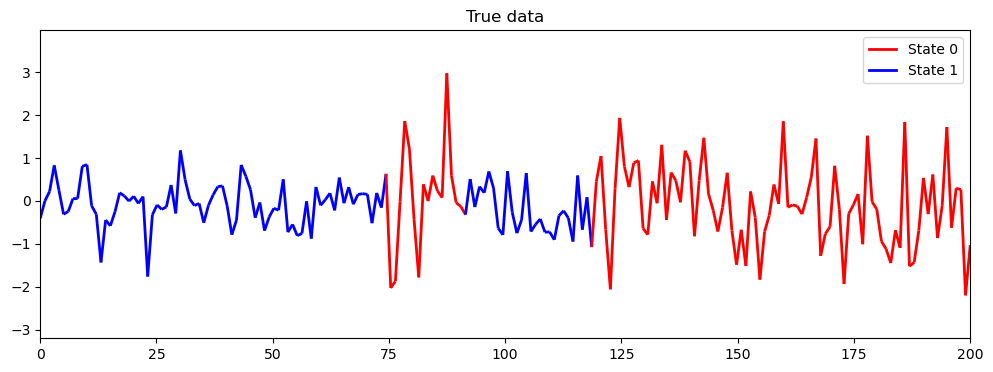

In [5]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(12, 4))
# plt.plot(trajectory_generator.traj[:, 0, 0], cmap=plt.cm.jet, color= trajectory_generator.state_sequence.squeeze())
x = np.linspace(0, 200, 200)
y = trajectory_generator.traj[:, 0, 0]
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# print(segments.shape)

colors = trajectory_generator.state_sequence.squeeze()
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-.5, .5, 1.5, 2.5], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(colors)
lc.set_linewidth(2)
line = plt.gca().add_collection(lc)
# fig.colorbar(line)
z = np.unique(colors)

def make_proxy(zvalue, scalar_mappable, **kwargs):
    color = scalar_mappable.cmap(scalar_mappable.norm(zvalue))
    return Line2D([0, 1], [0, 1], color=color, **kwargs)
proxies = [make_proxy(item, lc, linewidth=2) for item in z]
plt.legend(proxies, ['State 0', 'State 1', 'State 2'], frameon=True)

plt.title('True data')
plt.xlim(x.min(), x.max())
plt.ylim(y.min()-1, y.max()+1)
plt.show()

In [6]:
y = trajectory_generator.traj[:, 0, 0]
new_arr = np.expand_dims(y, axis=(1, 2))

import IHMM

difference = False  # take first order difference of solute trajectories
observation_model='AR'  # assume an autoregressive model
order = 1  # autoregressive order
max_states = 20
traj_no = 0 # np.arange(10).tolist()# [2]# None # np.arange(24)#2
first_frame = 7000  # frame after which simulation is equilibrated
dim = [1]
prior = 'MNIW-N'  # MNIW-N or MNIW
link = False  # link trajectories and add phantom state
parameterize_each = True
hyperparams = {'mu0': np.array([2.54])}
#hyperparams = {'mu0': np.array([1]), 'sig0': np.array([1.5])}
#hyperparams = None

# You can define a dictionary with some spline paramters
spline_params = {'npts_spline': 10, 'save': True, 'savename': 'spline_hdphmm.pl'}

ihmm = IHMM.InfiniteHMM(new_arr, traj_no=traj_no, load_com=False, difference=difference, observation_model=observation_model, order=order, 
                          max_states=max_states, first_frame=first_frame, dim=dim, spline_params=spline_params,
                          prior=prior, link=link, parameterize_each=parameterize_each, hyperparams=hyperparams)


Fitting 1 1 dimensional trajectories assuming an autoregressive order of 1
[1.2931]
[0.3878]
mu0 adjust from  [0.3878] to  [2.54]


In [7]:
niter = 1000
ihmm.inference(niter)

  0%|          | 2/1000 [00:00<01:10, 14.07it/s]

100%|██████████| 1000/1000 [01:15<00:00, 13.28it/s]


Found 2 unique states
[0.9847 1.    ]


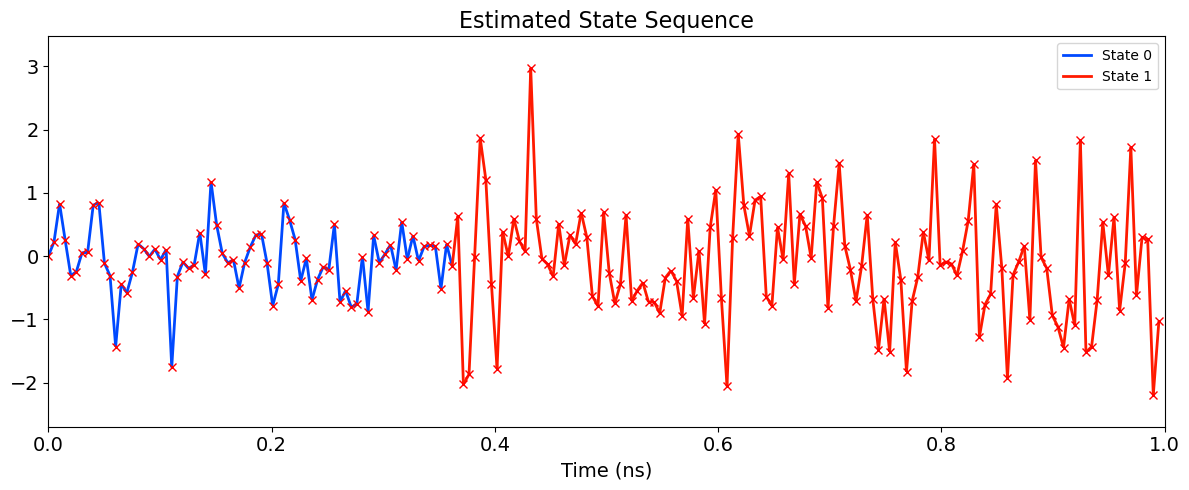

In [8]:
summarize_results(ihmm)
size = len(y[1:])
x = np.linspace(0, 1-(1/(size+1)), size)
plt.plot(x, y[1:], 'rx', label='obs')
plt.show()

In [9]:
import distrax as dx
import jax.random as jrnd
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
key = jrnd.PRNGKey(1234)

2024-06-06 15:33:46.631806: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [12]:
mu = np.zeros(size)
cov = np.zeros(size)
for i, z in enumerate(ihmm.z.squeeze()):
    # mu[i] = ihmm.theta['mu'].squeeze()[z]
    mu[i] = ihmm.theta['mu'].squeeze()[z] + ihmm.theta['A'].squeeze()[z] * y[i]
    cov[i] = 1/ihmm.theta['invSigma'].squeeze()[z]
MVN = dx.MultivariateNormalDiag(mu, cov)
print(MVN.log_prob(y[1:]))

/home/davcic/.conda/envs/CPJax/lib/python3.10/site-packages/distrax/_src/bijectors/shift.py:62: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.zeros(batch_shape, dtype=x.dtype)


-273.48358


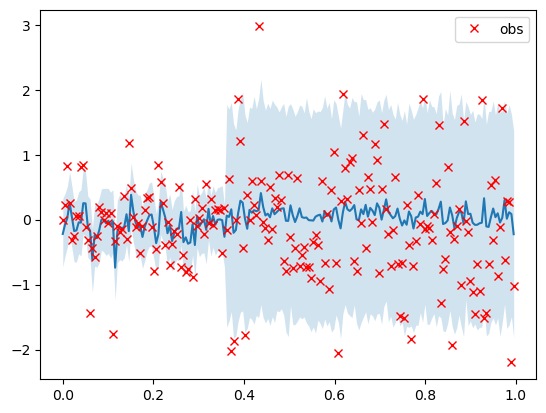

In [13]:
samples = MVN.sample(seed = key, sample_shape = 1000)

f_hdi_lower = np.percentile(samples, q=2.5, axis=0)
f_hdi_upper = np.percentile(samples, q=97.5, axis=0)
# f_hdi_lower = jnp.percentile(f_pred, q=2.5, axis=0)
# f_hdi_upper = jnp.percentile(f_pred, q=97.5, axis=0)

plt.plot(x, np.mean(samples.T, axis = 1))

plt.fill_between(x, f_hdi_lower, f_hdi_upper,
                 alpha=0.2, color='tab:blue', lw=0)

plt.plot(x, y[1:], 'rx', label='obs')
plt.legend()
plt.show()

## IHMM Metrics

In [14]:
def metric1_IHMM(ihmm, true_number):
    estimated_states = ihmm.z[traj_no, :]
    found_states = len(np.unique(estimated_states))-1
    max_num = np.maximum(ihmm.max_states - true_number, true_number)
    return (found_states - true_number)/max_num

In [15]:
def metric2_IHMM(ihmm, true_locations, size):
    x = np.linspace(0, 1, size)
    estimated_states = ihmm.z[0, :]
    CP_loc = np.where(estimated_states[:-1] != estimated_states[1:])[0] + 1
    CP_IHMM = x[CP_loc]
    found_states = len(CP_IHMM)
    dist = np.zeros((len(true_locations), found_states))
    max_num = ihmm.max_states
    max_dist = 1
    for i, loc in enumerate(true_locations):
        true_locs = np.sort(x[np.argsort(np.abs(x - loc))[:2]])
        dist1 = (CP_IHMM - true_locs[0])
        dist2 = (CP_IHMM - true_locs[1])
        dist_comp = dist1 * dist2
        dist_min = np.minimum(np.abs(dist1), np.abs(dist2))
        dist_min[dist_comp < 0] = 0
        dist[i, :] = np.abs(dist_min)
    num_diff = np.abs(len(true_locations) - found_states)
    sorted_min_dist = np.sort(np.min(dist, axis = 1))
    if num_diff == 0:
        return np.sum(sorted_min_dist)/max_num
    else: 
        sorted_min_dist[-num_diff:] = max_dist
        return np.sum(sorted_min_dist)/max_num

In [16]:
def metric3_IHMM(ihmm, y):
    size = len(y)-1
    mu = np.zeros(size)
    cov = np.zeros(size)
    for i, z in enumerate(ihmm.z.squeeze()):
        # mu[i] = ihmm.theta['mu'].squeeze()[z]
        mu[i] = ihmm.theta['mu'].squeeze()[z] + ihmm.theta['A'].squeeze()[z] * y[i]
        cov[i] = 1/ihmm.theta['invSigma'].squeeze()[z]
    MVN = dx.MultivariateNormalDiag(mu, cov)
    return MVN.log_prob(y[1:])

In [23]:
def metric4_IHMM(ihmm, true_locations, size):
    size = len(ihmm.z[0, :])
    estimated_states = ihmm.z[0, :]
    CP_loc = np.where(estimated_states[:-1] != estimated_states[1:])[0] + 1
    true_matrix = np.zeros((size,size))
    cov_matrix = np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            if (np.sum(i < CP_loc) == np.sum(j < CP_loc)):
                cov_matrix[i, j] = 1
            if (np.sum(i < true_locations) == np.sum(j < true_locations)):
                true_matrix[i, j] = 1
    return np.sum(1 - np.abs(cov_matrix - true_matrix))/(size**2)

In [25]:
z = trajectory_generator.state_sequence.squeeze()
size = len(z)
x = np.linspace(0, 1, size)
true_loc = x[np.where(z[:-1] != z[1:])[0]] + 1
true_num = len(true_loc)
y = trajectory_generator.traj[:, 0, 0]

M1_IHMM = metric1_IHMM(ihmm, true_num)
# M1_GP = metric1_GP(mgp_particles, true_num)
print(f"# of CP score for IHMM: {M1_IHMM}")
# print(f"# of CP score for GP: {M1_GP}")
print('--------------------------------------')

M2_IHMM = metric2_IHMM(ihmm, true_loc, size)
# M2_GP = metric2_GP(mgp_particles, true_loc, size)
print(f"location of CP score for IHMM: {M2_IHMM}")
# print(f"location of CP score for GP: {M2_GP}")
print('--------------------------------------')


M3_IHMM = metric3_IHMM(ihmm, y)
# M3_GP = metric3_GP(key, gp_marginal, mgp_particles, y)
print(f"likelihood for IHMM: {M3_IHMM}")
# print(f"likelihood for GP: {M3_GP}")
print('--------------------------------------')

M4_IHMM = metric4_IHMM(ihmm, true_loc, y)
# M3_GP = metric3_GP(key, gp_marginal, mgp_particles, y)
print(f"Jaccard index for IHMM: {M4_IHMM}")

# of CP score for IHMM: -0.11764705882352941
--------------------------------------
location of CP score for IHMM: 0.1316582914572864
--------------------------------------
likelihood for IHMM: -273.48358154296875
--------------------------------------
Jaccard index for IHMM: 0.5439509103305472
